<a href="https://colab.research.google.com/github/aditya89bh/agi-projects/blob/main/moe_expert_choice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Sparse MoE with Expert Choice Routing...
Using device: cuda
Model has 735007 parameters
Epoch 0, Batch 0, Loss: 198.5426, Main: 14.2226, Load Balance: 184.319992
Epoch 0, Batch 10, Loss: 190.1731, Main: 5.8531, Load Balance: 184.319992
Epoch 0, Batch 20, Loss: 188.0149, Main: 3.6949, Load Balance: 184.319992
Epoch 0, Batch 30, Loss: 187.1446, Main: 2.8246, Load Balance: 184.319992
Epoch 0, Batch 40, Loss: 186.8057, Main: 2.4857, Load Balance: 184.319992
Epoch 0, Batch 50, Loss: 186.5255, Main: 2.2055, Load Balance: 184.319992
Epoch 0, Batch 60, Loss: 186.4806, Main: 2.1606, Load Balance: 184.319992
Epoch 0, Batch 70, Loss: 186.5063, Main: 2.1863, Load Balance: 184.319992
Epoch 0, Batch 80, Loss: 186.3682, Main: 2.0482, Load Balance: 184.319992
Epoch 0, Batch 90, Loss: 186.4210, Main: 2.1010, Load Balance: 184.319992
Epoch 0, Batch 100, Loss: 186.3587, Main: 2.0387, Load Balance: 184.319992
Epoch 0, Batch 110, Loss: 186.3034, Main: 1.9834, Load Balance: 184.319992
Epoch 0, Batc

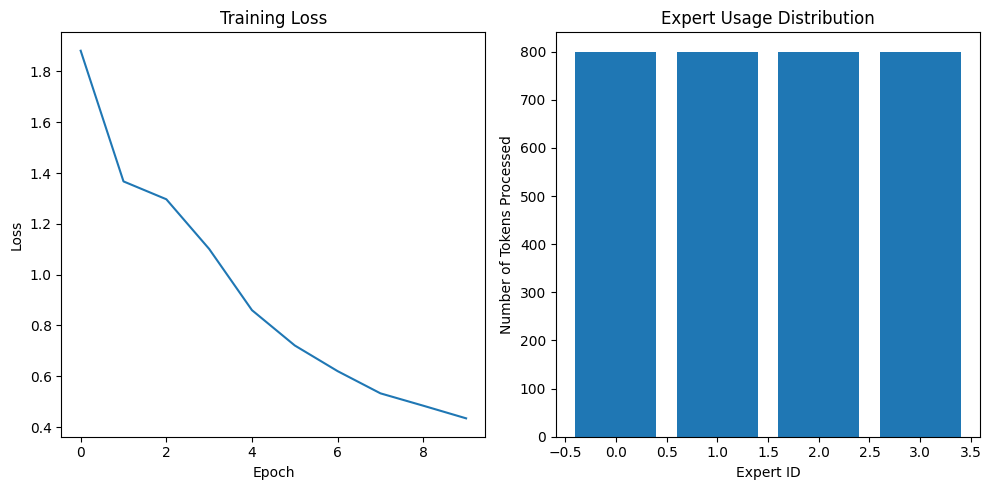


Generating sample text:
The telkkkkententl kkkkkkkkkkkkkkkkkkententlkentlke kkkkkkentlkentlkentlkentllllllMiokencicicokenciokadintencincincincincincincincincincincincincncncncncntentencompetecincicicicincicicicincicicicicincinci

Expert usage statistics:
Expert 0: 800 tokens
Expert 1: 800 tokens
Expert 2: 800 tokens
Expert 3: 800 tokens

Training completed successfully!


In [1]:
"""
Sparse Mixture-of-Experts with Expert Choice Routing
Implementation for research and educational purposes

This implementation includes:
1. Expert Choice Routing mechanism
2. Load balancing
3. Training utilities
4. Example usage with language modeling
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Tuple, Optional, List
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class ExpertChoiceRouter(nn.Module):
    """
    Expert Choice Router: Each expert selects top-k tokens to process
    instead of tokens selecting experts.
    """
    def __init__(self, d_model: int, num_experts: int, expert_capacity: int):
        super().__init__()
        self.d_model = d_model
        self.num_experts = num_experts
        self.expert_capacity = expert_capacity

        # Router network - produces expert preferences for tokens
        self.router = nn.Linear(d_model, num_experts, bias=False)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input tensor [batch_size, seq_len, d_model]

        Returns:
            expert_weights: Router weights [batch_size, seq_len, num_experts]
            expert_indices: Which tokens each expert processes [num_experts, expert_capacity]
            token_to_expert: Mapping from tokens to experts [batch_size, seq_len]
        """
        batch_size, seq_len, d_model = x.shape

        # Get router logits for each token
        router_logits = self.router(x)  # [batch_size, seq_len, num_experts]
        router_probs = F.softmax(router_logits, dim=-1)

        # Flatten for expert choice
        flat_probs = router_probs.view(-1, self.num_experts)  # [batch_size*seq_len, num_experts]

        # Expert Choice: Each expert picks top-k tokens
        expert_indices = torch.zeros(self.num_experts, self.expert_capacity, dtype=torch.long, device=x.device)
        expert_weights = torch.zeros(self.num_experts, self.expert_capacity, device=x.device)
        token_to_expert = torch.full((batch_size * seq_len,), -1, dtype=torch.long, device=x.device)

        for expert_id in range(self.num_experts):
            # Get this expert's preferences for all tokens
            expert_scores = flat_probs[:, expert_id]  # [batch_size*seq_len]

            # Select top-k tokens for this expert
            top_values, top_indices = torch.topk(expert_scores,
                                               min(self.expert_capacity, len(expert_scores)),
                                               dim=0)

            # Store the selected tokens and their weights
            actual_capacity = len(top_indices)
            expert_indices[expert_id, :actual_capacity] = top_indices
            expert_weights[expert_id, :actual_capacity] = top_values

            # Mark these tokens as assigned to this expert
            token_to_expert[top_indices] = expert_id

        # Reshape router_probs back to original shape for compatibility
        return router_probs, expert_indices, token_to_expert

class MoEExpert(nn.Module):
    """Individual expert network (simple FFN)"""
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self.dropout(F.relu(self.w1(x))))

class SparseExpertChoiceMoE(nn.Module):
    """
    Sparse Mixture-of-Experts with Expert Choice Routing
    """
    def __init__(self, d_model: int, num_experts: int, d_ff: int,
                 expert_capacity: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_experts = num_experts
        self.expert_capacity = expert_capacity

        # Router
        self.router = ExpertChoiceRouter(d_model, num_experts, expert_capacity)

        # Experts
        self.experts = nn.ModuleList([
            MoEExpert(d_model, d_ff, dropout) for _ in range(num_experts)
        ])

        # Load balancing
        self.load_balance_loss_coeff = 0.01

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input tensor [batch_size, seq_len, d_model]

        Returns:
            output: MoE output [batch_size, seq_len, d_model]
            load_balance_loss: Load balancing auxiliary loss
        """
        batch_size, seq_len, d_model = x.shape

        # Get routing decisions
        router_probs, expert_indices, token_to_expert = self.router(x)

        # Flatten input for expert processing
        flat_x = x.view(-1, d_model)  # [batch_size*seq_len, d_model]

        # Initialize output
        output = torch.zeros_like(flat_x)

        # Process tokens through their assigned experts
        for expert_id, expert in enumerate(self.experts):
            # Get tokens assigned to this expert
            expert_token_indices = expert_indices[expert_id]
            expert_weights_for_tokens = self.router.router(flat_x)[expert_token_indices, expert_id]

            # Filter out padding (where index might be 0 but not actually assigned)
            mask = expert_token_indices < batch_size * seq_len
            valid_indices = expert_token_indices[mask]
            valid_weights = expert_weights_for_tokens[mask]

            if len(valid_indices) > 0:
                # Get input tokens for this expert
                expert_input = flat_x[valid_indices]  # [num_selected_tokens, d_model]

                # Process through expert
                expert_output = expert(expert_input)  # [num_selected_tokens, d_model]

                # Weight the expert output
                weighted_output = expert_output * valid_weights.unsqueeze(-1)

                # Add to final output
                output[valid_indices] += weighted_output

        # Reshape back to original dimensions
        output = output.view(batch_size, seq_len, d_model)

        # Calculate load balancing loss
        load_balance_loss = self._calculate_load_balance_loss(router_probs, expert_indices)

        return output, load_balance_loss

    def _calculate_load_balance_loss(self, router_probs: torch.Tensor,
                                   expert_indices: torch.Tensor) -> torch.Tensor:
        """Calculate load balancing auxiliary loss"""
        # Expert utilization (how many tokens each expert processes)
        expert_counts = torch.zeros(self.num_experts, device=router_probs.device)
        for expert_id in range(self.num_experts):
            expert_counts[expert_id] = (expert_indices[expert_id] >= 0).sum().float()

        # Target: uniform distribution
        total_tokens = router_probs.shape[0] * router_probs.shape[1]
        target_count = total_tokens / self.num_experts

        # Load balance loss: encourage uniform expert utilization
        load_balance_loss = F.mse_loss(expert_counts,
                                     torch.full_like(expert_counts, target_count))

        return self.load_balance_loss_coeff * load_balance_loss

class TransformerWithMoE(nn.Module):
    """Simple transformer with MoE layer for demonstration"""
    def __init__(self, vocab_size: int, d_model: int, nhead: int, num_layers: int,
                 num_experts: int, d_ff: int, expert_capacity: int, max_seq_len: int = 512):
        super().__init__()
        self.d_model = d_model

        # Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(max_seq_len, d_model))

        # Transformer layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            # Attention layer
            attention = nn.MultiheadAttention(d_model, nhead, batch_first=True)
            # MoE layer
            moe = SparseExpertChoiceMoE(d_model, num_experts, d_ff, expert_capacity)
            # Layer norms
            norm1 = nn.LayerNorm(d_model)
            norm2 = nn.LayerNorm(d_model)

            self.layers.append(nn.ModuleDict({
                'attention': attention,
                'moe': moe,
                'norm1': norm1,
                'norm2': norm2
            }))

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        seq_len = x.shape[1]

        # Embeddings
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = x + self.pos_embedding[:seq_len]

        total_load_balance_loss = 0

        # Transformer layers
        for layer in self.layers:
            # Self-attention
            residual = x
            x = layer['norm1'](x)
            attn_output, _ = layer['attention'](x, x, x, attn_mask=mask)
            x = residual + attn_output

            # MoE
            residual = x
            x = layer['norm2'](x)
            moe_output, load_balance_loss = layer['moe'](x)
            x = residual + moe_output
            total_load_balance_loss += load_balance_loss

        # Output
        logits = self.output_projection(x)

        return logits, total_load_balance_loss

# Example dataset for language modeling
class SimpleTextDataset(Dataset):
    """Simple character-level dataset for demonstration"""
    def __init__(self, text: str, seq_len: int = 128):
        self.seq_len = seq_len

        # Create character vocabulary
        self.chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

        # Encode text
        self.data = [self.char_to_idx[ch] for ch in text]

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long),
                torch.tensor(self.data[idx + 1:idx + self.seq_len + 1], dtype=torch.long))

def train_model():
    """Training loop example"""
    # Sample text data (you can replace with your own dataset)
    sample_text = """
    The field of artificial intelligence has seen remarkable progress in recent years,
    particularly in the area of large language models. Mixture-of-experts architectures
    represent an important advancement that allows models to scale efficiently by
    activating only a subset of parameters for each input. Expert choice routing
    further improves this by allowing experts to select which tokens to process,
    leading to better load balancing and computational efficiency.
    """ * 10  # Repeat for more training data

    # Hyperparameters
    vocab_size = len(set(sample_text))
    d_model = 128
    nhead = 4
    num_layers = 2
    num_experts = 4
    d_ff = 256
    expert_capacity = 32
    seq_len = 64
    batch_size = 8
    learning_rate = 1e-3
    num_epochs = 10

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create dataset
    dataset = SimpleTextDataset(sample_text, seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Create model
    model = TransformerWithMoE(
        vocab_size=dataset.vocab_size,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        num_experts=num_experts,
        d_ff=d_ff,
        expert_capacity=expert_capacity
    ).to(device)

    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_load_balance_loss = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            logits, load_balance_loss = model(inputs)

            # Calculate main loss (cross-entropy)
            main_loss = F.cross_entropy(logits.reshape(-1, dataset.vocab_size), targets.reshape(-1))

            # Total loss
            total_loss = main_loss + load_balance_loss

            # Backward pass
            total_loss.backward()
            optimizer.step()

            epoch_loss += main_loss.item()
            epoch_load_balance_loss += load_balance_loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {total_loss.item():.4f}, '
                      f'Main: {main_loss.item():.4f}, Load Balance: {load_balance_loss.item():.6f}')

        avg_loss = epoch_loss / len(dataloader)
        avg_lb_loss = epoch_load_balance_loss / len(dataloader)
        losses.append(avg_loss)

        print(f'Epoch {epoch} completed. Avg Loss: {avg_loss:.4f}, Avg LB Loss: {avg_lb_loss:.6f}')

    return model, losses, dataset

def generate_text(model, dataset, seed_text: str, length: int = 100):
    """Generate text using the trained model"""
    model.eval()
    device = next(model.parameters()).device

    # Convert seed text to indices
    seed_indices = [dataset.char_to_idx.get(ch, 0) for ch in seed_text]
    generated = seed_indices.copy()

    with torch.no_grad():
        for _ in range(length):
            # Take last seq_len tokens as input
            input_seq = generated[-64:] if len(generated) >= 64 else generated
            input_tensor = torch.tensor([input_seq], device=device)

            # Get prediction
            logits, _ = model(input_tensor)
            next_token_logits = logits[0, -1, :]

            # Sample next token (with temperature)
            temperature = 0.8
            probs = F.softmax(next_token_logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, 1).item()

            generated.append(next_token)

    # Convert back to text
    return ''.join([dataset.idx_to_char[idx] for idx in generated])

# Example usage and analysis
def analyze_expert_usage(model, dataset, num_samples: int = 100):
    """Analyze how experts are being used"""
    model.eval()
    device = next(model.parameters()).device

    expert_usage = {i: 0 for i in range(model.layers[0]['moe'].num_experts)}

    # Create some sample inputs
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(dataloader):
            if batch_idx >= num_samples // 4:
                break

            inputs = inputs.to(device)

            # Get routing information from first MoE layer
            x = model.embedding(inputs) * math.sqrt(model.d_model)
            x = x + model.pos_embedding[:inputs.shape[1]]

            # Process through first layer to get MoE routing
            layer = model.layers[0]
            x = layer['norm1'](x)
            attn_output, _ = layer['attention'](x, x, x)
            x = x + attn_output
            x = layer['norm2'](x)

            # Get routing decisions
            router_probs, expert_indices, token_to_expert = layer['moe'].router(x)

            # Count expert usage
            for expert_id in range(model.layers[0]['moe'].num_experts):
                expert_usage[expert_id] += (expert_indices[expert_id] >= 0).sum().item()

    return expert_usage

# Main execution
if __name__ == "__main__":
    print("Training Sparse MoE with Expert Choice Routing...")

    # Train the model
    model, losses, dataset = train_model()

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Analyze expert usage
    expert_usage = analyze_expert_usage(model, dataset)

    plt.subplot(1, 2, 2)
    experts = list(expert_usage.keys())
    usage_counts = list(expert_usage.values())
    plt.bar(experts, usage_counts)
    plt.title('Expert Usage Distribution')
    plt.xlabel('Expert ID')
    plt.ylabel('Number of Tokens Processed')

    plt.tight_layout()
    plt.show()

    # Generate some sample text
    print("\nGenerating sample text:")
    sample_generation = generate_text(model, dataset, "The ", length=200)
    print(sample_generation)

    print(f"\nExpert usage statistics:")
    for expert_id, count in expert_usage.items():
        print(f"Expert {expert_id}: {count} tokens")

    print("\nTraining completed successfully!")